
## How to formulate the problem


In [1]:
import pandas as pd

data = pd.read_csv('./data/hero-network.csv')

heroes = {
    'MEDUSA/MEDUSALITH AM',
    'ARCLIGHT/PHILLIPA SO',
    'WOLVERINE/LOGAN ',
    'SCARLET WITCH/WANDA ',
    'ARAGORN',
    'OVERMIND/GROM',
    'BATTLEAXE/',
    'ION/',
    'PINK PEARL/'
}

relations = data[(data.hero1.isin(heroes)) & (data.hero2.isin(heroes))]
relations = pd.DataFrame(np.sort(relations.values, axis=1), columns=relations.columns).drop_duplicates(subset=['hero1', 'hero2'])

relations.head()
#CAPTION Load the data from the csv-file

,hero1,hero2
0,SCARLET WITCH/WANDA,WOLVERINE/LOGAN
4,MEDUSA/MEDUSALITH AM,WOLVERINE/LOGAN
5,ARAGORN,SCARLET WITCH/WANDA
7,MEDUSA/MEDUSALITH AM,SCARLET WITCH/WANDA
8,OVERMIND/GROM,SCARLET WITCH/WANDA


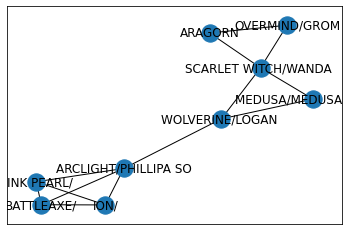

In [2]:
import networkx as nx

graph = nx.from_pandas_edgelist(relations, source='hero1', target='hero2')
nx.draw_networkx(graph)
#CAPTION Representing the data as a graph

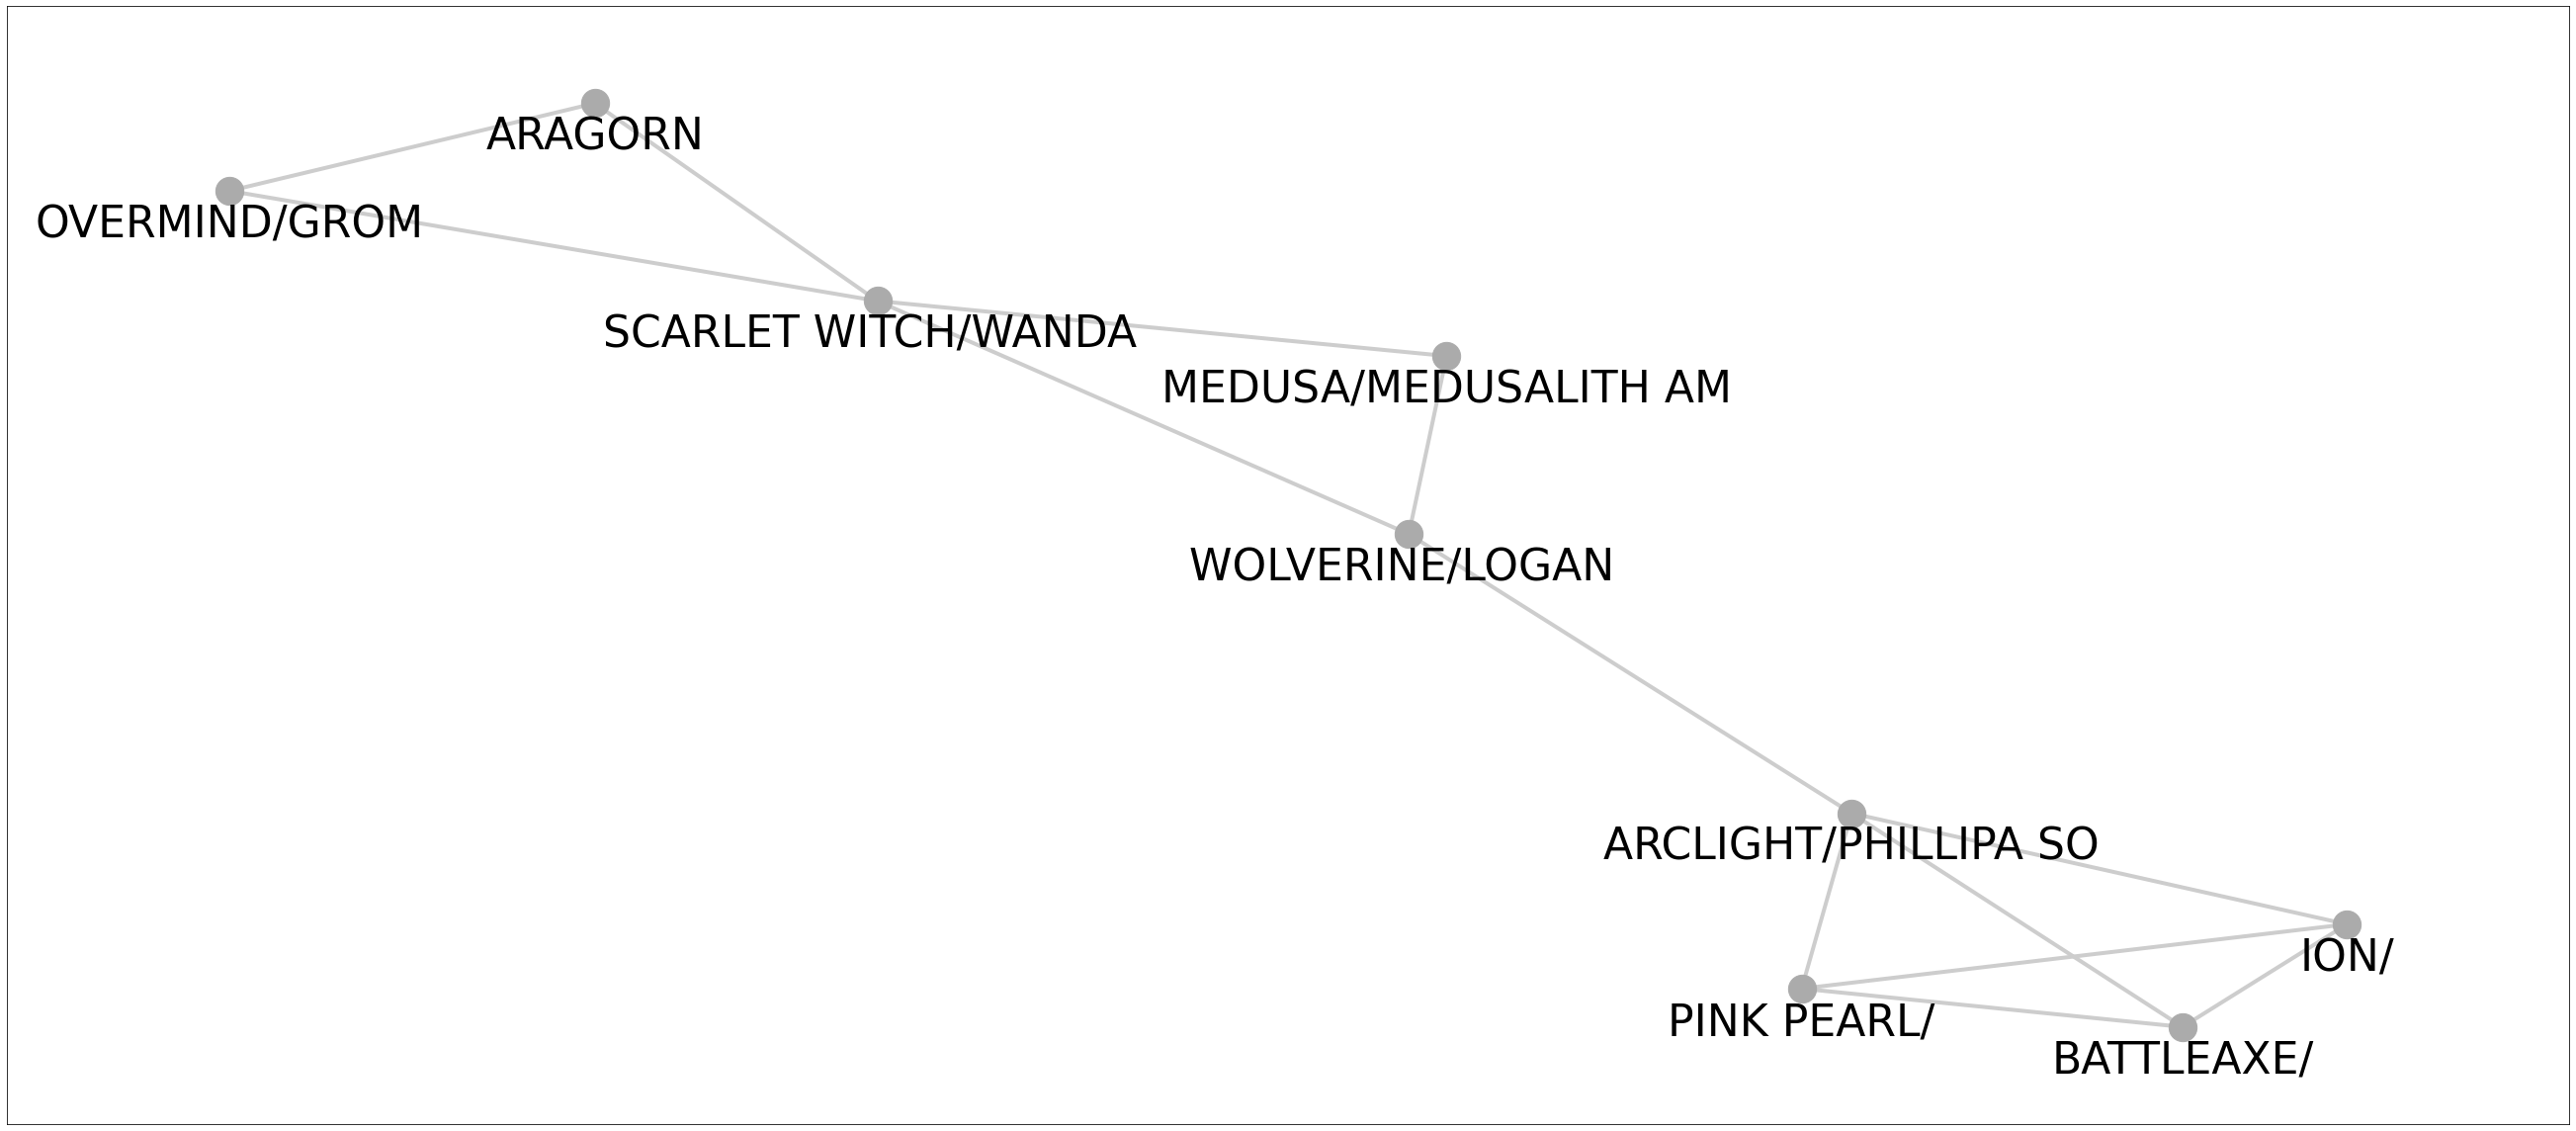

In [4]:
#SKIPCELL
plt.figure(1,figsize=(12,2.5)) 
plt.tight_layout()
plt.subplots_adjust(bottom=-5.4, right=1.5, left=-1.5)

def nudge(pos, x_shift, y_shift):
    return {n:(x + x_shift, y + y_shift) for n,(x,y) in pos.items()}

pos = nx.spring_layout(graph)
pos_nodes = nudge(pos, 0, -0.07)

nx.draw_networkx_nodes(graph, pos=pos, node_color="#ABABAB", node_size=800)   # default nodes and edges
nx.draw_networkx_edges(graph, pos, width=4, edge_color ="#CDCDCD")
labels=nx.draw_networkx_labels(graph,pos=pos_nodes, font_color="#000", font_size=44)
plt.show()

In [5]:
matrix = nx.to_pandas_adjacency(graph, dtype=int)
#CAPTION Representing the data as a matrix

In [6]:

from collections import defaultdict
from functools import reduce
from itertools import product
import numpy as np
from qiskit import Aer, QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit.visualization import plot_histogram, plot_bloch_multivector
import numpy as np
from scipy.optimize import minimize_scalar, minimize
from numpy import pi
import random

PAULIS = {
    "I": np.eye(2, dtype=complex),
    "X": np.array([[0, 1], [1, 0]], dtype=complex),
    "Y": np.array([[0, -1j], [1j, 0]], dtype=complex),
    "Z": np.array([[1, 0], [0, -1]], dtype=complex),
}


def pauli_decomposition(H):
    n = int(np.log2(len(H)))
    dims = 2 ** n

    if H.shape != (dims, dims):
        raise ValueError("The input must be a 2^n x 2^n dimensional matrix.")

    basis_key = ["".join(k) for k in product(PAULIS.keys(), repeat=n)]
    components = defaultdict(int)

    for i, val in enumerate(product(PAULIS.values(), repeat=n)):
        basis_mat = reduce(np.kron, val)
        coeff = H.reshape(-1).dot(basis_mat.reshape(-1)) / dims
        coeff = np.real_if_close(coeff).item()
        
        if not np.allclose(coeff, 0):
            components[basis_key[i]] = coeff

    return components


def matrix_decomposition_circuits(H,add_ansatz):
    n = int(np.log2(len(H)))
    dims = 2 ** n

    if H.shape != (dims, dims):
        raise ValueError("The input must be a 2^n x 2^n dimensional matrix.")

    components = pauli_decomposition(H)
    
    circuits = {}
    for (paulistring, weight) in components.items():
        paulis = list(enumerate(reversed(paulistring)))
        
        qr = QuantumRegister(n, "qr")
        cr = ClassicalRegister(1, "cr")
        qc = QuantumCircuit(qr, cr)
        
        add_ansatz(qc, qr)

        # don't do anything if all Paulis are I
        if all(x[1] == "I" for x in paulis):
            # we use this empty circuit that we will measure as "0" (eigenvalue 1) in all cases
            circuits[paulistring] = (qc, weight)
            continue
        
        # do the single qubit transformations
        for idx, letter in paulis:
            if letter == "X":
                qc.h(qr[idx])
            elif letter == "Y":
                qc.h(qr[idx])
                qc.sdg(qr[idx])
                
        # add the inter-qubit gates
        for idx, (first, second) in enumerate(zip(paulis, paulis[1:])):
            if second[1] == "I":
                qc.swap(first[0], second[0])
            elif first[1] != "I":
                paulis[idx+1] = (paulis[idx+1][0], paulis[idx][1])
                qc.cx(first[0], second[0])
            
        # measure the highest qubit
        qc.measure(qr[-1], cr[0])
        circuits[paulistring] = (qc, weight)
        
    return circuits

def ansatz(qc, qr, thetas, rounds=3):
    for r in range(rounds):
        for i in range(len(qr)):
            offset = r*len(qr)*2 +i*2
            
            qc.ry(thetas[offset], qr[i])
            qc.rz(thetas[offset+1], qr[i])
            
            if i > 0 and r < rounds - 1:
                qc.cx(qr[i-1], qr[i])
            
    return qc


def run_circuit(circuit, backend, shots=1000):
    result = execute(circuit, backend, shots=shots).result()
    counts = result.get_counts()
    return (
        (counts["0"] if "0" in counts.keys() else 0)
        - (counts["1"] if "1" in counts.keys() else 0)
    )/shots
    
    
def expectation(H, rounds, thetas):
    backend = Aer.get_backend('qasm_simulator')
    circuits = matrix_decomposition_circuits(
        H,
        lambda qc, qr: ansatz(qc, qr, thetas, rounds)
    )
    
    return sum(map(lambda key: run_circuit(circuits[key][0], backend)*circuits[key][1], circuits.keys()))

class SPSA:
    
    def __init__(self, a, c, A, alpha, gamma, H, loss_function):
        # Initialize gain parameters and decay factors
        self.a = a
        self.c = c
        self.A = A
        self.alpha = alpha
        self.gamma = gamma
        self.loss_function = loss_function

        # counters
        self.t = 0
        

    def step(self, current_estimate):
        # get the current values for gain sequences
        a_t = self.a / (self.t + 1 + self.A)**self.alpha
        c_t = self.c / (self.t + 1)**self.gamma

        # get the random perturbation vector from bernoulli distribution
        delta = np.random.randint(0,2, np.array(current_estimate).shape) * 2 - 1
        
        # measure the loss function at perturbations
        loss_plus = self.loss_function(current_estimate + delta * c_t)
        loss_minus = self.loss_function(current_estimate - delta * c_t)
        
        # compute the estimate of the gradient
        g_t = (loss_plus - loss_minus) / (2.0 * delta * c_t)
        
        # update the estimate of the parameter
        current_estimate = current_estimate - a_t * g_t

        # increment the counter
        self.t += 1

        return current_estimate

def vqe(H, rounds, max_iter, thetas=None, save_steps=None):
    
    cnt_qubits = int(np.log2(len(H)))
    if thetas is None:
        thetas = list(map(
                lambda x: random.random(),
                [0] * ((1+rounds)*cnt_qubits*2)
            ))
    
    # create the optimizer class
    optimizer = SPSA(
        a=0.9,
        c=1.0,
        A=max_iter/10,
        alpha=0.6,
        gamma=0.1,
        H=H,
        loss_function=lambda t_thetas: expectation(H, rounds, t_thetas))

    # the main loop
    for i in range(max_iter):
        thetas = optimizer.step(thetas)
        
        if save_steps is not None and i % save_steps == 0:
            yield (i, thetas, expectation(H, rounds, thetas))

    return (thetas, expectation(H, rounds, thetas))
#CAPTION The Variational Quantum Eigensolver

In [7]:
H = np.array(
    [[0, 1, 1, 1, 0, 0, 0, 0],
     [1, 0, 1, 0, 1, 0, 0, 0],
     [1, 1, 0, 0, 0, 0, 0, 0],
     [1, 0, 0, 0, 0, 0, 0, 0],
     [0, 1, 0, 0, 0, 1, 1, 1],
     [0, 0, 0, 0, 1, 0, 1, 1],
     [0, 0, 0, 0, 1, 1, 0, 1],
     [0, 0, 0, 0, 1, 1, 1, 0]],
    dtype=complex
)

result = None
step_size = 3
for step in vqe(H, rounds=3, max_iter=60, save_steps=step_size):
    print('Step {step}. Current expectation value: {ev: .3f}'.format(step=step[0], ev=step[2]))
    result = step
    
print('The solution is: \n'+str(result[1]))
print('The lowest expectation value is: {ev: .3f}'.format(ev=result[2]))
#CAPTION Solving an exemplary problem

Step 0. Current expectation value: -0.307
Step 3. Current expectation value: -0.524
Step 6. Current expectation value: -0.157
Step 9. Current expectation value: -0.725
Step 12. Current expectation value: -0.754
Step 15. Current expectation value: -0.300
Step 18. Current expectation value: -0.599
Step 21. Current expectation value: -0.650
Step 24. Current expectation value: -0.540
Step 27. Current expectation value: -0.756
Step 30. Current expectation value: -0.822
Step 33. Current expectation value: -0.726
Step 36. Current expectation value: -0.761
Step 39. Current expectation value: -0.760
Step 42. Current expectation value: -0.743
Step 45. Current expectation value: -0.757
Step 48. Current expectation value: -0.808
Step 51. Current expectation value: -0.886
Step 54. Current expectation value: -1.029
Step 57. Current expectation value: -1.031
The solution is: 
[-0.07344113 -0.44491251  1.44064064  0.9459133   0.95641657  0.46458815
 -0.00254454  0.22926408 -0.01859977  1.17317468  0.1